In [ ]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import pandas as pd
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import f1_score
import os
from PIL import Image


In [ ]:
# Load CSV file
csv_path = '/content/drive/My Drive/Colab Notebooks/Neural Network CMU/HW2_Malaria_Detection/dataset/train_data.csv'
images_path = '/content/drive/My Drive/Colab Notebooks/Neural Network CMU/HW2_Malaria_Detection/dataset/train_images'

# Reading the CSV file
df = pd.read_csv(csv_path)

# Create a dictionary to map image names to their labels
labels_dict = pd.Series(df.label.values,index=df.img_name).to_dict()


In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ToTensor(),  # Convert images to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet stats
])


In [ ]:
# Load images and labels
images = []
labels = []

for img_name in os.listdir(images_path):
    if img_name in labels_dict:
        img_path = os.path.join(images_path, img_name)
        img = Image.open(img_path).convert('RGB')  # Ensure image is RGB
        img = transform(img)  # Apply transformations
        images.append(img)
        labels.append(labels_dict[img_name])

# Convert lists to tensors
images = torch.stack(images)
labels = torch.tensor(labels)


In [ ]:
# Split dataset
dataset_size = len(images)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

import random
random.seed(14)
torch.manual_seed(14)
if torch.cuda.is_available():
  torch.cuda.manual_seed(14)


train_dataset, val_dataset = random_split(list(zip(images, labels)), [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 56 * 56)  # Adjust size here depending on your image input size
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
import torch.optim as optim
from sklearn.metrics import f1_score
import numpy as np


def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10, device='cuda'):
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'train_f1': [], 'val_f1': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total = 0
        all_labels = []
        all_preds = []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct_preds += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_acc = correct_preds / total
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)

        # Validation
        model.eval()
        running_loss = 0.0
        correct_preds = 0
        total = 0
        all_labels = []
        all_preds = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct_preds += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

        val_loss = running_loss / len(val_loader)
        val_acc = correct_preds / total
        val_f1 = f1_score(all_labels, all_preds, average='weighted')
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Train F1 Score: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val F1 Score: {val_f1:.4f}')

    return history




In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(train_acc, val_acc):
    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [ ]:
# Assuming you've defined your custom model as SimpleCNN()
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

simple_cnn_history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)


Epoch [1/10], Train Loss: 17.2276, Train Accuracy: 0.5721, Train F1 Score: 0.5721, Val Loss: 0.6429, Val Accuracy: 0.6717, Val F1 Score: 0.6722
Epoch [2/10], Train Loss: 0.6196, Train Accuracy: 0.6642, Train F1 Score: 0.6636, Val Loss: 0.6103, Val Accuracy: 0.6917, Val F1 Score: 0.6916
Epoch [3/10], Train Loss: 0.6104, Train Accuracy: 0.6758, Train F1 Score: 0.6757, Val Loss: 0.6289, Val Accuracy: 0.6467, Val F1 Score: 0.6435
Epoch [4/10], Train Loss: 0.6092, Train Accuracy: 0.6717, Train F1 Score: 0.6692, Val Loss: 0.6049, Val Accuracy: 0.6550, Val F1 Score: 0.6297
Epoch [5/10], Train Loss: 0.5935, Train Accuracy: 0.6837, Train F1 Score: 0.6831, Val Loss: 0.5865, Val Accuracy: 0.7033, Val F1 Score: 0.7038
Epoch [6/10], Train Loss: 0.5887, Train Accuracy: 0.6858, Train F1 Score: 0.6847, Val Loss: 0.5878, Val Accuracy: 0.7217, Val F1 Score: 0.7205
Epoch [7/10], Train Loss: 0.5578, Train Accuracy: 0.7129, Train F1 Score: 0.7125, Val Loss: 0.5677, Val Accuracy: 0.7117, Val F1 Score: 0.711

In [ ]:
import torch.nn as nn
import torchvision.models as models

def get_vgg19(num_classes=2):
    model = models.vgg19(pretrained=True)
    # Modify the classifier
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    return model

def get_resnet(num_classes=2):
    model = models.resnet50(pretrained=True)
    # Modify the fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

def get_mobilenet_v2(num_classes=2):  # Update `num_classes` to match your dataset
    # Load the pre-trained model
    model = models.mobilenet_v2(pretrained=True)
    # Replace the classifier layer to match the number of classes
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    return model


In [ ]:
!pip install timm
import timm



def get_efficientnet(model_name='efficientnet_b0', num_classes=2, pretrained=True):
    # Load a pre-trained model
    model = timm.create_model(model_name, pretrained=pretrained)
    # Adapt the classifier to the number of classes
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
    return model

def get_resnet_101(num_classes=2, pretrained=True):
    # Load the pre-trained ResNet-101 model
    model = models.resnet101(pretrained=pretrained)
    # Replace the last fully connected layer (fc) to match the number of classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model

def get_resnet_152(num_classes=2, pretrained=True):
    # Load the pre-trained ResNet-152 model
    model = models.resnet152(pretrained=pretrained)
    # Replace the last fully connected layer (fc) to match the number of classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model


In [ ]:
vgg19_model = get_vgg19(num_classes=2)  # Assuming binary classification
resnet_model = get_resnet(num_classes=2)

vgg19_optimizer = optim.Adam(vgg19_model.parameters(), lr=0.0001)
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Example of training VGG19 - adapt for ResNet similarly
vgg19_history = train_model(vgg19_model, criterion, vgg19_optimizer, train_loader, val_loader, epochs=10)
resnet_history = train_model(resnet_model, criterion, resnet_optimizer, train_loader, val_loader, epochs=10)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 90.6MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future.

Epoch [1/10], Train Loss: 0.2571, Train Accuracy: 0.9117, Train F1 Score: 0.9116, Val Loss: 0.1503, Val Accuracy: 0.9667, Val F1 Score: 0.9667
Epoch [2/10], Train Loss: 0.1471, Train Accuracy: 0.9579, Train F1 Score: 0.9579, Val Loss: 0.1527, Val Accuracy: 0.9683, Val F1 Score: 0.9684
Epoch [3/10], Train Loss: 0.1200, Train Accuracy: 0.9650, Train F1 Score: 0.9650, Val Loss: 0.1326, Val Accuracy: 0.9650, Val F1 Score: 0.9650
Epoch [4/10], Train Loss: 0.0866, Train Accuracy: 0.9700, Train F1 Score: 0.9700, Val Loss: 0.1692, Val Accuracy: 0.9633, Val F1 Score: 0.9634
Epoch [5/10], Train Loss: 0.0961, Train Accuracy: 0.9729, Train F1 Score: 0.9729, Val Loss: 0.1651, Val Accuracy: 0.9600, Val F1 Score: 0.9600
Epoch [6/10], Train Loss: 0.0793, Train Accuracy: 0.9783, Train F1 Score: 0.9783, Val Loss: 0.1669, Val Accuracy: 0.9667, Val F1 Score: 0.9667
Epoch [7/10], Train Loss: 0.0771, Train Accuracy: 0.9767, Train F1 Score: 0.9767, Val Loss: 0.1815, Val Accuracy: 0.9617, Val F1 Score: 0.9617

In [ ]:
mobilenet_v2 = get_mobilenet_v2(num_classes=2)  # Change `num_classes` as required
mob_optimizer = torch.optim.Adam(mobilenet_v2.parameters(), lr=0.00001)

resnet101_model = get_resnet_101(num_classes=2)
resnet152_model = get_resnet_152(num_classes=2)

# Function to get NAdam optimizer
def get_nadam_optimizer(model, lr=0.0001):
    return optim.NAdam(model.parameters(), lr=lr)

# Example of how to instantiate a ResNet-101 model and NAdam optimizer

resnet101_optimizer = get_nadam_optimizer(resnet101_model, lr=0.0001)
resnet152_optimizer = get_nadam_optimizer(resnet152_model, lr=0.0001)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet101_model.to(device)


mobilenet_v2_history = train_model(
    mobilenet_v2, criterion, mob_optimizer, train_loader, val_loader, epochs=10, device=device
)

resnet101_history = train_model(
    resnet101_model, criterion, resnet101_optimizer, train_loader, val_loader, epochs=10, device=device
)

resnet152_history = train_model(
    resnet152_model, criterion, resnet152_optimizer, train_loader, val_loader, epochs=10, device=device
)



Epoch [1/10], Train Loss: 0.4492, Train Accuracy: 0.8254, Train F1 Score: 0.8244, Val Loss: 0.2718, Val Accuracy: 0.9233, Val F1 Score: 0.9234
Epoch [2/10], Train Loss: 0.2273, Train Accuracy: 0.9313, Train F1 Score: 0.9312, Val Loss: 0.1749, Val Accuracy: 0.9533, Val F1 Score: 0.9534
Epoch [3/10], Train Loss: 0.1580, Train Accuracy: 0.9508, Train F1 Score: 0.9508, Val Loss: 0.1508, Val Accuracy: 0.9550, Val F1 Score: 0.9550
Epoch [4/10], Train Loss: 0.1249, Train Accuracy: 0.9571, Train F1 Score: 0.9571, Val Loss: 0.1447, Val Accuracy: 0.9600, Val F1 Score: 0.9600
Epoch [5/10], Train Loss: 0.1004, Train Accuracy: 0.9667, Train F1 Score: 0.9667, Val Loss: 0.1397, Val Accuracy: 0.9583, Val F1 Score: 0.9584
Epoch [6/10], Train Loss: 0.0856, Train Accuracy: 0.9704, Train F1 Score: 0.9704, Val Loss: 0.1414, Val Accuracy: 0.9533, Val F1 Score: 0.9534
Epoch [7/10], Train Loss: 0.0787, Train Accuracy: 0.9742, Train F1 Score: 0.9742, Val Loss: 0.1449, Val Accuracy: 0.9533, Val F1 Score: 0.9534

In [ ]:
print(torch.__version__)

2.2.1+cu121


In [ ]:
efficientnet = get_efficientnet(model_name='efficientnet_b0', num_classes=2)
optimizer = torch.optim.Adam(efficientnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet.to(device)

# Train the model
efficientnet_history = train_model(
    efficientnet, criterion, optimizer, train_loader, val_loader, epochs=10, device=device
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epoch [1/10], Train Loss: 0.1844, Train Accuracy: 0.9313, Train F1 Score: 0.9312, Val Loss: 0.3779, Val Accuracy: 0.8600, Val F1 Score: 0.8595
Epoch [2/10], Train Loss: 0.1190, Train Accuracy: 0.9613, Train F1 Score: 0.9612, Val Loss: 0.1449, Val Accuracy: 0.9567, Val F1 Score: 0.9567
Epoch [3/10], Train Loss: 0.0736, Train Accuracy: 0.9750, Train F1 Score: 0.9750, Val Loss: 0.1647, Val Accuracy: 0.9583, Val F1 Score: 0.9584
Epoch [4/10], Train Loss: 0.0791, Train Accuracy: 0.9746, Train F1 Score: 0.9746, Val Loss: 0.1532, Val Accuracy: 0.9633, Val F1 Score: 0.9634
Epoch [5/10], Train Loss: 0.0732, Train Accuracy: 0.9688, Train F1 Score: 0.9687, Val Loss: 0.1291, Val Accuracy: 0.9550, Val F1 Score: 0.9550
Epoch [6/10], Train Loss: 0.0485, Train Accuracy: 0.9846, Train F1 Score: 0.9846, Val Loss: 0.1599, Val Accuracy: 0.9617, Val F1 Score: 0.9617
Epoch [7/10], Train Loss: 0.0300, Train Accuracy: 0.9883, Train F1 Score: 0.9883, Val Loss: 0.2379, Val Accuracy: 0.9617, Val F1 Score: 0.9616

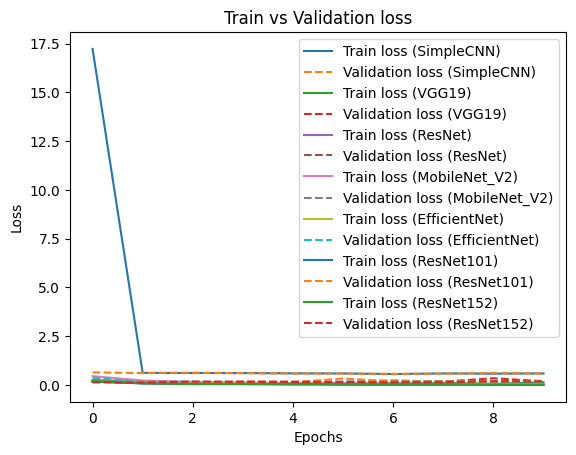

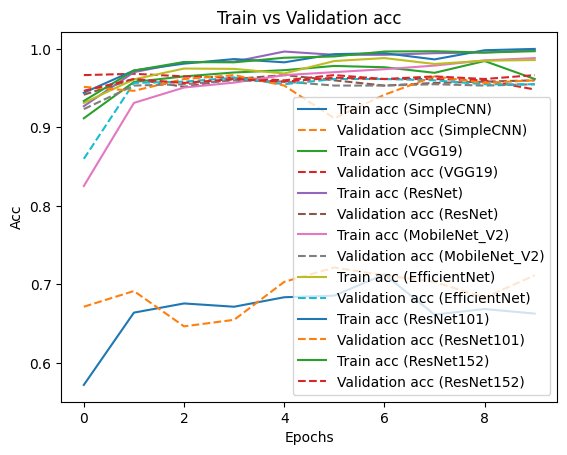

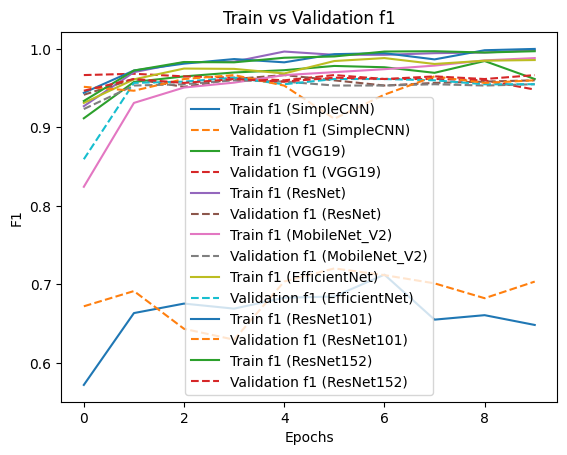

The model with the best F1 score is ResNet152 with an F1 score of 0.9667.


In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(histories, model_names, metric):
    for history, model_name in zip(histories, model_names):
        plt.plot(history[f'train_{metric}'], label=f'Train {metric} ({model_name})')
        plt.plot(history[f'val_{metric}'], '--', label=f'Validation {metric} ({model_name})')

    plt.title(f'Train vs Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

# Assuming simple_cnn_history, vgg19_history, and resnet_history are dictionaries containing metrics
model_histories = [simple_cnn_history, vgg19_history, resnet_history, mobilenet_v2_history, efficientnet_history, resnet101_history, resnet152_history]
model_names = ['SimpleCNN', 'VGG19', 'ResNet', 'MobileNet_V2', 'EfficientNet','ResNet101', 'ResNet152']

# Plot Loss, Accuracy, and F1 Score
plot_metrics(model_histories, model_names, 'loss')
plot_metrics(model_histories, model_names, 'acc')
plot_metrics(model_histories, model_names, 'f1')

# Determine which model has the best final F1 score on validation set
final_val_f1_scores = [history['val_f1'][-1] for history in model_histories]
best_model_index = final_val_f1_scores.index(max(final_val_f1_scores))
best_model_name = model_names[best_model_index]
best_f1_score = final_val_f1_scores[best_model_index]

print(f'The model with the best F1 score is {best_model_name} with an F1 score of {best_f1_score:.4f}.')


Let's add more image augmentation and see if that helps with our accuracy.

In [ ]:

train_transforms = transforms.Compose([
    # augmentation for training
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    # Standard transformations for validation (no augmentation)
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset.transform = train_transforms
val_dataset.transform = val_transforms

# Create the data loaders with the newly defined transforms
train_aug_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [ ]:
import warnings
warnings.filterwarnings("ignore")


simple_cnn_aug_history = train_model(model, criterion, optimizer, train_aug_loader, val_loader, epochs=10)
vgg19_aug_history = train_model(vgg19_model, criterion, vgg19_optimizer, train_aug_loader, val_loader, epochs=10)
resnet_aug_history = train_model(resnet_model, criterion, resnet_optimizer, train_aug_loader, val_loader, epochs=10)

mobilenet_v2_aug_history = train_model(
    mobilenet_v2, criterion, optimizer, train_aug_loader, val_loader, epochs=10, device=device
)

efficientnet_aug_history = train_model(
    efficientnet, criterion, optimizer, train_aug_loader, val_loader, epochs=10, device=device
)

resnet101_aug_history = train_model(
    resnet101_model, criterion, resnet101_optimizer, train_aug_loader, val_loader, epochs=10, device=device
)

resnet152_aug_history = train_model(
    resnet152_model, criterion, resnet152_optimizer, train_aug_loader, val_loader, epochs=10, device=device
)

Epoch [1/10], Train Loss: 0.5925, Train Accuracy: 0.6529, Train F1 Score: 0.6265, Val Loss: 0.5811, Val Accuracy: 0.7217, Val F1 Score: 0.7159
Epoch [2/10], Train Loss: 0.5892, Train Accuracy: 0.6442, Train F1 Score: 0.6162, Val Loss: 0.5824, Val Accuracy: 0.7150, Val F1 Score: 0.7084
Epoch [3/10], Train Loss: 0.6009, Train Accuracy: 0.6275, Train F1 Score: 0.5944, Val Loss: 0.5820, Val Accuracy: 0.7167, Val F1 Score: 0.7109
Epoch [4/10], Train Loss: 0.5905, Train Accuracy: 0.6325, Train F1 Score: 0.6001, Val Loss: 0.5817, Val Accuracy: 0.7150, Val F1 Score: 0.7084
Epoch [5/10], Train Loss: 0.5942, Train Accuracy: 0.6404, Train F1 Score: 0.6094, Val Loss: 0.5827, Val Accuracy: 0.7133, Val F1 Score: 0.7066
Epoch [6/10], Train Loss: 0.5949, Train Accuracy: 0.6312, Train F1 Score: 0.6018, Val Loss: 0.5828, Val Accuracy: 0.7167, Val F1 Score: 0.7103
Epoch [7/10], Train Loss: 0.5996, Train Accuracy: 0.6354, Train F1 Score: 0.6044, Val Loss: 0.5810, Val Accuracy: 0.7200, Val F1 Score: 0.7149

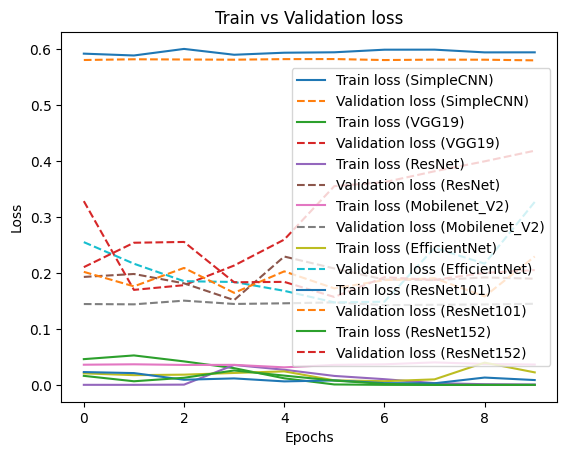

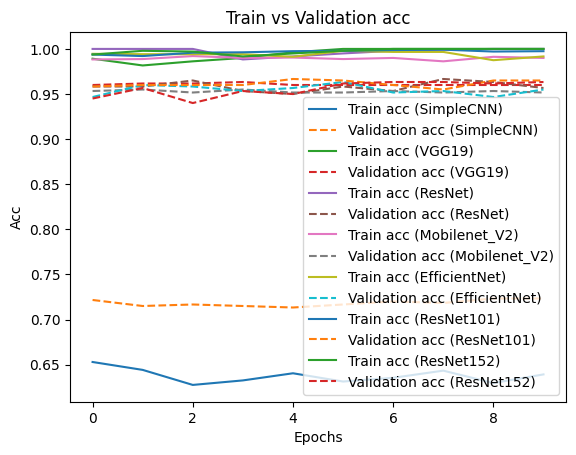

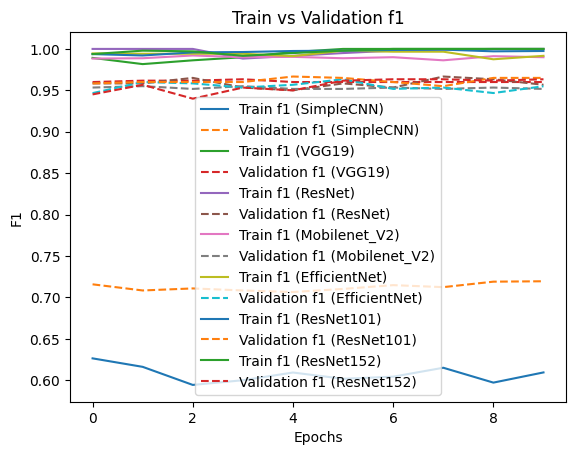

The model with the best F1 score is ResNet101 with an F1 score of 0.9650.


In [ ]:
model_histories = [simple_cnn_aug_history, vgg19_aug_history, resnet_aug_history, mobilenet_v2_aug_history, efficientnet_aug_history, resnet101_aug_history, resnet152_aug_history]
model_names = ['SimpleCNN', 'VGG19', 'ResNet', 'Mobilenet_V2', 'EfficientNet', 'ResNet101', 'ResNet152']

# Plot Loss, Accuracy, and F1 Score
plot_metrics(model_histories, model_names, 'loss')
plot_metrics(model_histories, model_names, 'acc')
plot_metrics(model_histories, model_names, 'f1')

# Determine which model has the best final F1 score on validation set
final_val_f1_scores = [history['val_f1'][-1] for history in model_histories]
best_model_index = final_val_f1_scores.index(max(final_val_f1_scores))
best_model_name = model_names[best_model_index]
best_f1_score = final_val_f1_scores[best_model_index]

print(f'The model with the best F1 score is {best_model_name} with an F1 score of {best_f1_score:.4f}.')


In [ ]:
# Output CSV

import pandas as pd
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

# Step 1: Define your Dataset class
class ImageFolderDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = [img for img in os.listdir(img_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)

        return image, self.img_names[idx]

# Define the transformations
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size expected by ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Replace 'test_images_dir' with the actual path to your directory of test images
test_dataset = ImageFolderDataset(img_dir='/content/drive/My Drive/Colab Notebooks/Neural Network CMU/HW2_Malaria_Detection/dataset/test_images', transform=test_transforms)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)




In [ ]:
# Step 2: Make Predictions

# choose the one that's best performing
resnet152_model.eval()  # Set the model to evaluation mode
resnet152_model.to('cuda')  # Send model to GPU

predictions = []
img_names = []

with torch.no_grad():
    for images, file_names in test_loader:
        images = images.to('cuda')
        outputs = resnet152_model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        img_names.extend(file_names)

# Step 3: Output to CSV
output_df = pd.DataFrame({
    'img_name': img_names,
    'label': predictions
})

# Define the path where you want to save the CSV file
output_csv_path = '/content/drive/My Drive/Colab Notebooks/Neural Network CMU/HW2_Malaria_Detection/dataset/predictions.csv'
output_df.to_csv(output_csv_path, index=False)

print(f'Predictions saved to {output_csv_path}')

Predictions saved to /content/drive/My Drive/Colab Notebooks/Neural Network CMU/HW2_Malaria_Detection/dataset/predictions.csv
